# Проект по предсказанию стоимости жилых квартир города Пермь 
### Был использован самостоятельно полученный с помощью веб-парсинга датасет с сайта avito.ru
Данные актуальны на конец января 2022 года

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae, r2_score as R2
from sklearn.model_selection import cross_val_score as cvs
from sklearn.ensemble import GradientBoostingRegressor

## Импорт и начальный вид данных

In [2]:
dataset = pd.read_csv('../python_learn/avito_flats.csv')
dataset.head(7)

,title,price,address,area,rooms,floors,house_type,construction_date,ceiling_height,link
0,"1-к. квартира, 42,3 м кв., 25/25 эт.",4018500.0,"ул. Кустовая, д. 2А",42.3,1,25 из 25,монолитный,1 кв. 2023 года,NaN,https://www.avito.ru/perm/kvartiry/1-k._kvarti...
1,"3-к. квартира, 44 м кв., 8/20 эт.",3873760.0,"ул. Краснополянская, д. 34",44.0,3,8 из 20,монолитный,3 кв. 2022 года,2.6,https://www.avito.ru/perm/kvartiry/3-k._kvarti...
2,"Квартира-студия, 23,8 м кв., 3/25 эт.",2320000.0,"ул. Солдатова, д. 30Б",23.8,студия,3 из 25,монолитный,4 кв. 2023 года,2.6,https://www.avito.ru/perm/kvartiry/kvartira-st...
3,"1-к. квартира, 46,9 м кв., 6/6 эт.",6097000.0,"ул. Екатерининская, д. 10",46.9,1,6 из 6,монолитный,2 кв. 2024 года,NaN,https://www.avito.ru/perm/kvartiry/1-k._kvarti...
4,"2-к. квартира, 79,3 м кв., 2/4 эт.",6937875.0,"ул. Борцов Революции, д. 1, корп. А, стр. 1",79.3,2,2 из 4,монолитный,4 кв. 2022 года,NaN,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
5,"2-к. квартира, 57,8 м кв., 10/25 эт.",5294480.0,"ул. Барамзиной, д. 38",57.8,2,10 из 25,монолитный,4 кв. 2022 года,2.7,https://www.avito.ru/perm/kvartiry/2-k._kvarti...
6,"Квартира-студия, 30,4 м кв., 5/11 эт.",2552760.0,"ул. Ласьвинская, д. 15",30.4,студия,5 из 11,кирпичный,1 кв. 2024 года,2.7,https://www.avito.ru/perm/kvartiry/kvartira-st...


In [3]:
def all_data_tranforms(df, ff=False, tar_norm=False, stand_sc=False):
    df = df.copy()
    
    # DROP
    df.drop(['title', 'link', 'address', 'ceiling_height', 'construction_date'], axis=1, inplace=True)
    df.dropna(how='all', inplace=True)

    # lat, long
    coor_df = pd.read_csv('../python_learn/csv_files/coor_avito_flats2.csv')
    df['lat'] = coor_df.lat
    df['lng'] = coor_df.lng
    
    # floors etc
    fract_floors = []
    building_flrs = []
    for i in df.floors:
        try:
    #         print(i.replace(' из ', ','), ' = ', i.replace(' из ', ',').split(',') )
            l = i.replace(' из ', ',').split(',')
            fract_floors.append(int(l[0])/int(l[1]))
            building_flrs.append(int(l[1]))
        except AttributeError:
            fract_floors.append(i)
            building_flrs.append(i)
    if ff:
        df['fract_flrs'] = fract_floors
    df['building_flrs'] = building_flrs
    df.drop(['floors'], axis=1, inplace=True)
    
    # rooms
    df.loc[df.rooms == 'студия', ['rooms']] = 0
    df.rooms = df.rooms.astype('int')
    
    # house_type
    ht = pd.get_dummies(df.house_type, prefix='type')
    df = df.join(ht)
    df.drop(['house_type'], axis=1, inplace=True)
    
    # drop nans in lat, lng
    df.dropna(axis=0, inplace=True)
    
    # price --- target
    if tar_norm:
        target = np.log(df.price)
    else:
        target = df.price
    df.drop(['price'], axis=1, inplace=True)
    
    if stand_sc:
        scaler = StandardScaler().fit(df)
        df = pd.DataFrame(scaler.transform(df))
            
    return df, target

# df, target = all_data_tranforms(dataset)

In [4]:
df, target = all_data_tranforms(dataset)

In [5]:
df.head(5)

,area,rooms,lat,lng,building_flrs,type_блочный,type_кирпичный,type_монолитный,type_панельный
0,42.3,1,57.969058,56.270723,25,0,0,1,0
1,44.0,3,57.967930,56.271902,20,0,0,1,0
2,23.8,0,57.971481,56.231502,25,0,0,1,0
3,46.9,1,58.012552,56.252127,6,0,0,1,0
4,79.3,2,58.027277,56.193065,4,0,0,1,0


In [6]:
df.shape, target.shape

((3832, 9), (3832,))

# Просмотр и преобразование данных
Как были получены признаки итоговой таблицы

In [78]:
df.rooms.value_counts()

2    1276
3    1061
1     909
0     521
4     277
Name: rooms, dtype: int64

## Координаты

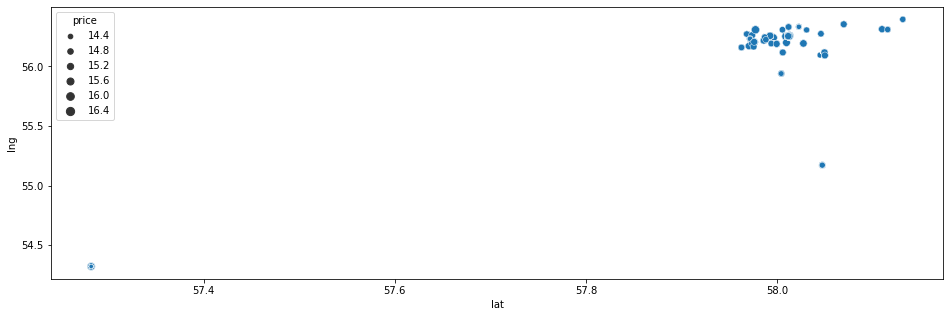

In [12]:
plt.figure(figsize=(16,5))
sns.scatterplot(
    data=df,
    x='lat',
    y='lng',
    size=target
)
plt.show()

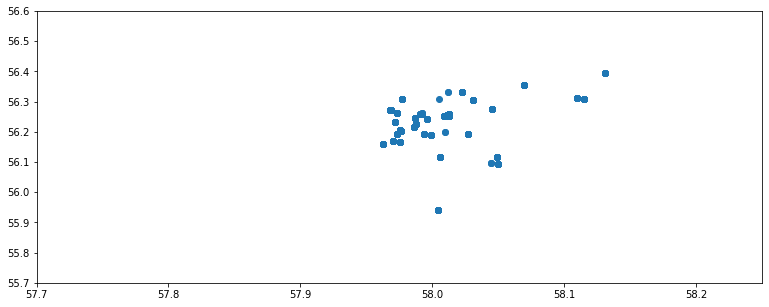

In [14]:
plt.figure(figsize=(13,5))
plt.xlim([57.7,58.25])
plt.ylim([55.7,56.6])
plt.scatter(df.lat, df.lng)
plt.show()

Координаты это очень условный признак в данном случае. Почему?

Координаты были получены скриптом в сторонний файл, через который они подружаются во фрейм в функции `all_data_transform`. Скрипт работал на основе геокодинга (получение широты и долготы) по текстовому адресу с помощью бесплатного сервиса Nominatim, который в свою очередь не отличается лучшим качеством. При геокодинге полного адреса (г.Пермь + название улицы + номер дома) было обнаружено, что примерно 1/3 геопозиций находятся вообще не в Перми. Когда же поиск осуществлялся без указания номера дома (г.Пермь + название улицы), то почти все позиции находились в пределах города, как и должно быть. Но в таком случае многие квартиры разных цен имеют одну и ту же координату, тк находятся на одной улице, но в разных домах

## Цена (target)
Лог-нормирование

<AxesSubplot:>

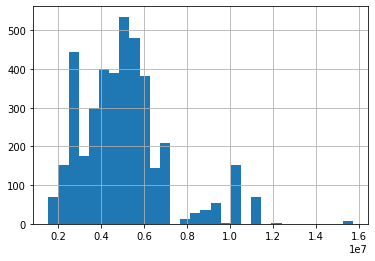

In [56]:
dataset.price.hist(bins=30)

<AxesSubplot:>

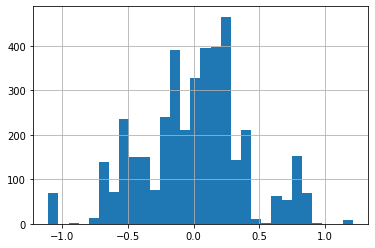

In [61]:
dataset['log_price'] = np.log(dataset.price)
dataset['log_price'] = dataset['log_price'] - dataset['log_price'].mean()
dataset.log_price.hist(bins=30)

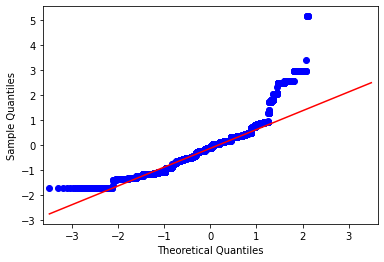

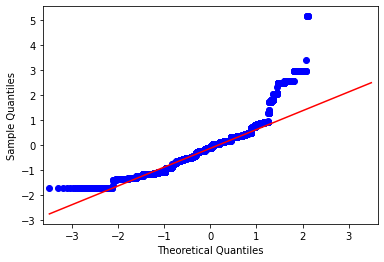

In [62]:
sm.qqplot(dataset.st_price, line='q')

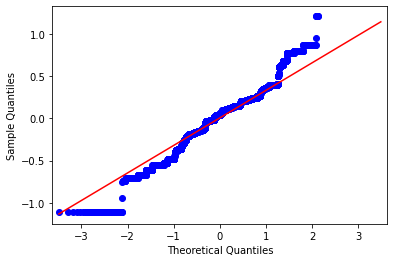

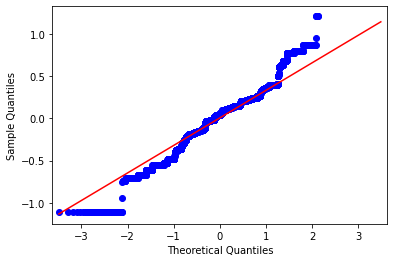

In [63]:
sm.qqplot(dataset.log_price, line='q')

Как видно, после логарифмирования целевого показателя его распределение становится более приближенным к нормальному. Но это лишь отчасти так. Благодаря графику квантилей видно, как после логарифмирования правый хвост распределение становится более нормального вида (точки верхней половины больше прижимаются к линии соответствия квантилей), но хвост слева от нуля на оборот вибивается. Даже если кажется это существенным, то на практике это почти никак не сказывалось, а в некоторых попытках предсказания моделей (, обучающихся на таргете без нормирования) были менее завышены.

## Тип дома

In [17]:
dataset.house_type.value_counts()

монолитный    2694
кирпичный      991
панельный      358
блочный          1
Name: house_type, dtype: int64

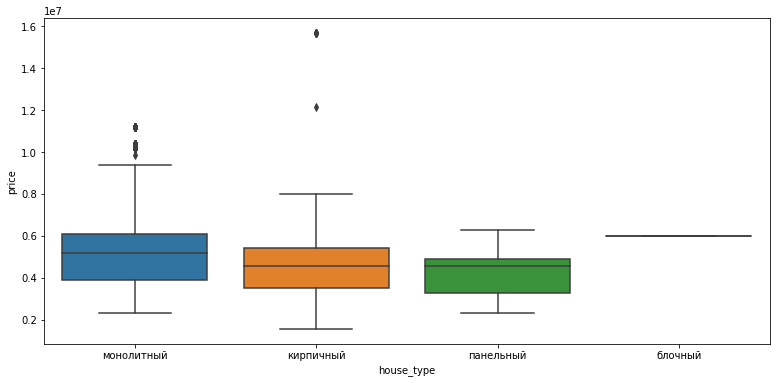

In [19]:
plt.figure(figsize=(13, 6))
sns.boxplot(
    x=dataset.house_type,
    y=dataset.price
)
plt.show()

## Высота потолков

Говорит, что есть такая хата, где высота потолков 42м

Но страница по ссылке уже не существует

In [21]:
df.ceiling_height.describe()

count    2178.000000
mean        2.748255
std         0.849718
min         2.000000
25%         2.700000
50%         2.700000
75%         2.700000
max        42.000000
Name: ceiling_height, dtype: float64

In [54]:
df.loc[df.ceiling_height == 42]

,title,price,address,area,rooms,floors,house_type,construction_date,ceiling_height,link,lat,lng,log_price
3338,"3-к. квартира, 58,9 м кв., 2/5 эт.",3800000.0,"Пермский край, Пермь, Вижайская ул., 23",58.9,3,2 из 5,кирпичный,1972,42.0,https://www.avito.ru/perm/kvartiry/3-k._kvarti...,58.01389,56.24889,15.150512


In [53]:
df.loc[df.ceiling_height == 42].link

3338    https://www.avito.ru/perm/kvartiry/3-k._kvarti...
Name: link, dtype: object

In [14]:
sum(df.ceiling_height.isnull()) # sum of nans in ceiling_height

1934

очевидно, что с 42мя метрами это выброс. Да и в целом нет смысла заморачиваться с высотой, тк почти у половины семплов нет значений и признак не особо вариативный

## 2 фичи из признака `floors`
1 - дробь, которая показывает насколько высоко в доме находится квартира (1 - последний этаж, близко к 0 - на первых этажах)

2 - сколько всего этажей в доме

In [62]:
fract_floors = []
building_flrs = []
for i in df.floors:
    try:
#         print(i.replace(' из ', ','), ' = ', i.replace(' из ', ',').split(',') )
        l = i.replace(' из ', ',').split(',')
        fract_floors.append(int(l[0])/int(l[1]))
        building_flrs.append(int(l[1]))
    except AttributeError:
        # если nan, то пусть останется nan'ом
        fract_floors.append(i)

In [63]:
fr_florrs = pd.Series(fract_floors)
sum(fr_florrs.isna())

68

In [80]:
df[df.isna().any(axis=1)]

,area,rooms,lat,lng,fract_flrs,building_flrs,type_блочный,type_кирпичный,type_монолитный,type_панельный
50,60.0,2,NaN,NaN,0.647059,17,0,0,0,1
56,55.9,2,NaN,NaN,0.142857,21,0,0,1,0
57,76.7,3,NaN,NaN,0.080000,25,0,0,1,0
109,60.0,2,NaN,NaN,0.647059,17,0,0,0,1
114,55.9,2,NaN,NaN,0.142857,21,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
3997,55.9,2,NaN,NaN,0.142857,21,0,0,1,0
4005,86.1,4,NaN,NaN,0.142857,21,0,0,1,0
4011,70.6,3,NaN,NaN,0.714286,21,0,0,1,0
4056,55.9,2,NaN,NaN,0.142857,21,0,0,1,0


212 строк с хотя бы одним НаНом в строке

In [82]:
for col in df.columns:
    print(col, '---', df[col].isna().any())

area --- False
rooms --- False
lat --- True
lng --- True
fract_flrs --- False
building_flrs --- False
type_блочный --- False
type_кирпичный --- False
type_монолитный --- False
type_панельный --- False


НаНы только в координатах

Поэтому добавим в главную функцию `all_data_transform` устранение этих строк через `.dropna()`

---

# baseline

In [7]:
train_data, test_data, train_target, test_target = train_test_split(
    df, target, test_size=0.2, random_state=2
)

## linear regression

In [8]:
test_target

180      6097000.0
2709     3221575.0
1337    10209000.0
3356     3400000.0
658      4989600.0
           ...    
3662     4000000.0
670     10379000.0
1378     2552760.0
3639     4989600.0
4035     2880000.0
Name: price, Length: 767, dtype: float64

In [30]:
lin = LinearRegression().fit(train_data, train_target)

np.mean(cvs(lin, test_data, test_target))

0.7540120034607917

In [31]:
mae(y_true=test_target, y_pred=lin.predict(test_data)), np.exp(mae(y_true=test_target, y_pred=lin.predict(test_data)))

(0.15005951541281382, 1.1619033918305586)

In [32]:
R2(y_true=test_target, y_pred=lin.predict(test_data))

0.769064201491879

## gbm

In [12]:
gbm = GradientBoostingRegressor(n_estimators=200, random_state=2).fit(train_data, train_target)

print(np.mean(cvs(gbm, test_data, test_target)))
print(cvs(gbm, test_data, test_target, cv=6))

0.9911233042035505
[0.99167217 0.97863965 0.99311721 0.99744286 0.99298517 0.9844626 ]


In [13]:
mae(y_true=test_target, y_pred=gbm.predict(test_data))

0.006946652058439414

In [40]:
np.exp(0.006946652058439414)

1.0069708360125893

In [14]:
R2(y_true=test_target, y_pred=gbm.predict(test_data))

0.9945725836193412

Чрезвычайно хороший результат.. Однако он на валидационной выборке. И это все таки квадрат остатков, а с практической точки зрения больше интересует абсолютное отклонение

Но в данном случае вычислять mae имеет смысл только в качестве сравнения с другими моделями, которые тоже обучаются по лог-нормированному таргету, поскольку ошибка не интерпретируется классическим способом в рубли

           Feature  Importance
0             area    0.786600
1            rooms    0.043546
2              lat    0.095191
3              lng    0.037087
4       fract_flrs    0.005311
5    building_flrs    0.029213
6     type_блочный    0.000000
7   type_кирпичный    0.000199
8  type_монолитный    0.001690
9   type_панельный    0.001164


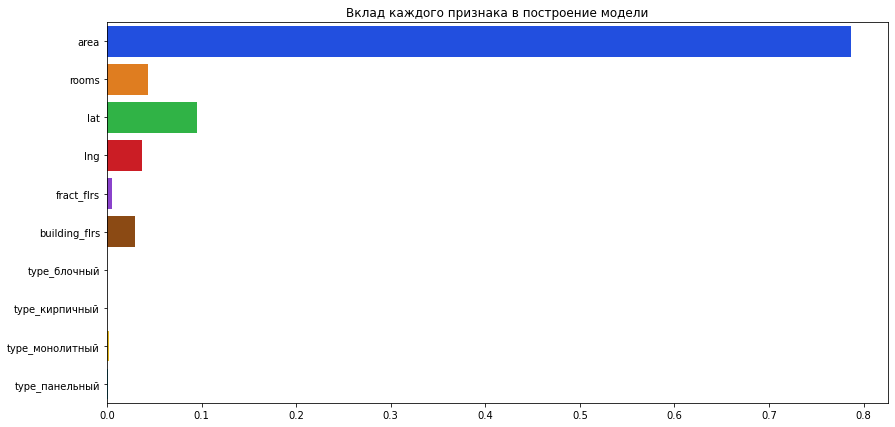

In [18]:
feat_imp = pd.DataFrame(data={'Feature': df.columns,
                              'Importance': gbm.feature_importances_})
print(feat_imp)

plt.figure(figsize=(14,7))
plt.title('Вклад каждого признака в построение модели')
sns.barplot(y=df.columns, x=gbm.feature_importances_, palette=sns.color_palette('bright', as_cmap=True))
plt.show()

После просмотра этого графика стало вдруг интересно - а есть ли на самом деле связь между придуманной фичей `fract_flrs` и таргетом?

Изначально было предположение, что квартиры, расположенные "повыше", стоят "подороже". Иными словами предпологалось, что есть прямая зависимость

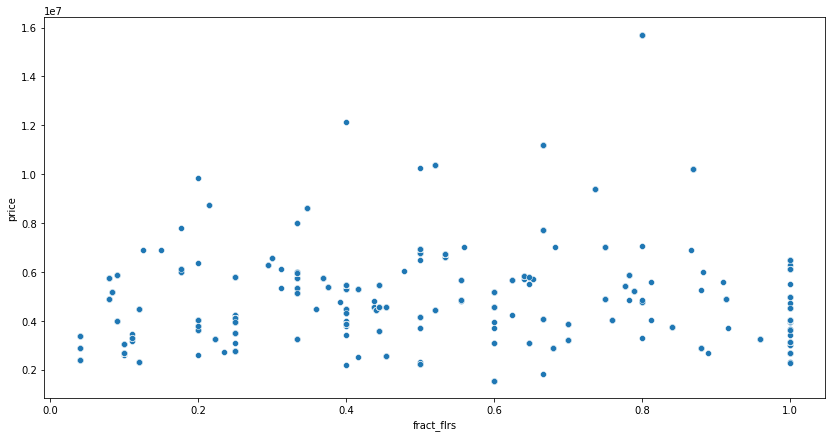

In [23]:
plt.figure(figsize=(14,7))
sns.scatterplot(
    x=df.fract_flrs,
    y=np.exp(target)
)
plt.show()

In [25]:
np.corrcoef(df.fract_flrs, np.exp(target))

array([[1.        , 0.14668097],
       [0.14668097, 1.        ]])

На самом деле существенной корреляции нет

## random forest

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(n_estimators=350, max_depth=7,
                           min_samples_split=2, random_state=2).fit(train_data, train_target)

print('mean cvs: ', np.mean(cvs(rf, test_data, test_target)))
print('cvs: ', cvs(rf, test_data, test_target, cv=6))
print('mae: ', mae(y_true=test_target, y_pred=rf.predict(test_data)))

mean cvs:  0.9716858388893111
cvs:  [0.95353303 0.92627176 0.97675504 0.99028389 0.98363906 0.98296534]
mae:  128014.20970001307


In [21]:
%%time
params = {
    'n_estimators': range(100, 400, 50),
    'max_depth': range(1, 8),
    'min_samples_split': range(2, 10, 2)
}

grid = GridSearchCV(rf, params, cv=5, verbose=2, n_jobs=-1)
grid.fit(train_data, train_target)

Fitting 5 folds for each of 168 candidates, totalling 840 fits
Wall time: 53min 11s


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(criterion='mae', random_state=2),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(100, 400, 50)},
             verbose=2)

In [22]:
grid.best_params_

({'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 350},
 0.9854509614839818)

# for people
Проверяем предикт для 3х квартир, которых нет в датасете, но их цены известны (автору)

### linear regression

In [33]:
flat_data = np.array([42,2,57.9923266,55.9269021,0.4,5,0,1,0,0]) # двушка 42м на Магистральной
flat_data2 = np.array([32,1,58.0129377,55.9670637,0.8,5,1,0,0,0]) # однушка 32м на Ямпольской
flat_data3 = np.array([88.2,2,58.0103762,56.2444499,0.67,6,1,0,0,0]) # новостройка с Циана - цена 7.7 млн руб

print(f'{int(np.exp(lin.predict(flat_data.reshape(1,-1))))} --- двушка 42м на Магистральной')
print(f'{int(np.exp(lin.predict(flat_data2.reshape(1,-1))))} --- однушка 32м на Ямпольской')
print(f'{int(np.exp(lin.predict(flat_data3.reshape(1,-1))))} --- двушка 82м на Екатерининская - 7700000')

3687853 --- двушка 42м на Магистральной
3254237 --- однушка 32м на Ямпольской
7249651 --- двушка 82м на Екатерининская - 7700000


### gbm

In [83]:
flat_data = np.array([42,2,57.9923266,55.9269021,0.4,5,0,1,0,0]) # двушка 42м на Магистральной
flat_data2 = np.array([32,1,58.0129377,55.9670637,0.8,5,1,0,0,0]) # однушка 32м на Ямпольской
flat_data3 = np.array([88.2,2,58.0103762,56.2444499,0.67,6,1,0,0,0]) # новостройка с Циана - цена 7.7 млн руб

print(f'{int(np.exp(gbm.predict(flat_data.reshape(1,-1))))} --- двушка 42м на Магистральной')
print(f'{int(np.exp(gbm.predict(flat_data2.reshape(1,-1))))} --- однушка 32м на Ямпольской')
print(f'{int(np.exp(gbm.predict(flat_data3.reshape(1,-1))))} --- двушка 82м на Екатерининская - 7700000')

3624670 --- двушка 42м на Магистральной
2569551 --- однушка 32м на Ямпольской
9042709 --- двушка 82м на Екатерининская - 7700000


Для коренного жителя Перми вывод очевиден - цены крайне завышены!(

Но почему?

In [28]:
vtorichka = 0
new_building = 0

for date in dataset.construction_date:
    try:
        int(date)
        vtorichka += 1
    except ValueError:
        new_building += 1

print('Количество квартир')
print('вторичка: ', vtorichka)
print('новостройки: ', new_building)

Количество квартир
вторичка:  107
новостройки:  4005


Мы научились предсказывать цену новостройки, а не вторички(99((

Очень мало семплов данных вторичного жилья, чтобы модель могла научиться снижать цену относительно новостроек. Да и к тому же фича с датой постройки не была использована вовсе, но если бы она все таки была, то фундаментально врядли что-нибудь поменялось из-за дисбаланса 

Но даже не смотря на обучение под цены новостроек, модель выдала 9млн для новостройки за 7.7млн. То есть, очевидно, что модель хорошо описывает специфику конкретного датасета, так как (условно) пример в сдругого датасета он предсказывает очень плохо 

# Крутим-вертим

- Удаляем `fract_flrs`
- Не нормируем таргет
- нормируем данные на вход
- Усиливаем регуляризацию модели
    - ставим критерий разбиения дерева и функцию потерь как mae
    - задаем макс глубину отдельного дерева

In [98]:
df, target = all_data_tranforms(dataset, ff=False, tar_norm=False, stand_sc=False)

In [99]:
df.head()

,area,rooms,lat,lng,building_flrs,type_блочный,type_кирпичный,type_монолитный,type_панельный
0,42.3,1,57.969058,56.270723,25,0,0,1,0
1,44.0,3,57.967930,56.271902,20,0,0,1,0
2,23.8,0,57.971481,56.231502,25,0,0,1,0
3,46.9,1,58.012552,56.252127,6,0,0,1,0
4,79.3,2,58.027277,56.193065,4,0,0,1,0


In [100]:
train_data, test_data, train_target, test_target = train_test_split(
    df, target, test_size=0.2, random_state=2
)

## gmb 2

In [102]:
%%time
gbm_2 = GradientBoostingRegressor(n_estimators=200,
                                  max_depth=2,
                                  max_features=6,
                                  min_samples_leaf=20,
                                  criterion='mae',
                                  loss='lad'
                                 ).fit(train_data, train_target)

Wall time: 23.4 s


In [103]:
cross = cvs(gbm_2, test_data, test_target, cv=6, scoring='r2')
print(round(np.mean(cross), 2), round(np.std(cross), 4))
print(cross)

0.95 0.0136
[0.941249   0.9349892  0.95578416 0.9731918  0.96860248 0.9515174 ]


In [104]:
print(round(mae(y_true=test_target, y_pred=gbm_2.predict(test_data)), 2), ' - средняя абсолютная ошибка (RUB)')

155848.39  - средняя абсолютная ошибка (RUB)


   Feature  Importance
0        0    0.408357
1        1    0.087745
2        2    0.210012
3        3    0.206770
4        4    0.062657
5        5    0.000000
6        6    0.001702
7        7    0.018453
8        8    0.004304


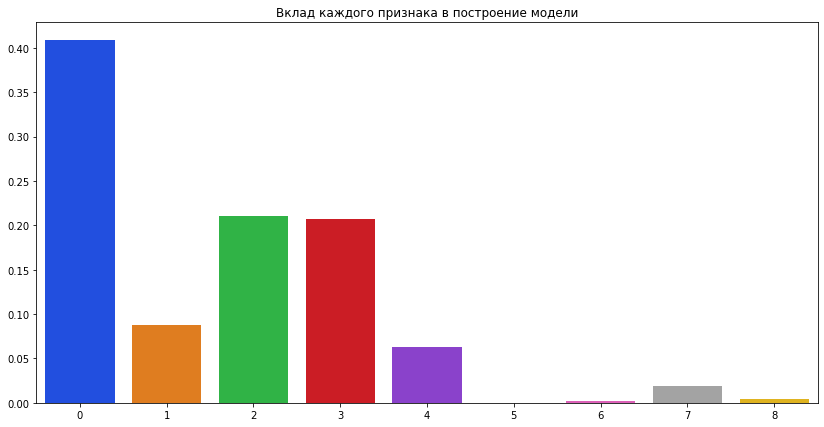

In [100]:
feat_imp = pd.DataFrame(data={'Feature': df.columns,
                              'Importance': gbm_2.feature_importances_})
print(feat_imp)

plt.figure(figsize=(14,7))
plt.title('Вклад каждого признака в построение модели')
sns.barplot(x=df.columns, y=gbm_2.feature_importances_, palette=sns.color_palette('bright', as_cmap=True))
plt.show()

------

# Небольшой итоговый отчет по моделям

5 примеров реальных квартир с правдоподобными ценами на момент создания датасета. С помощью них будем подводить наш *некорректный* итог

In [11]:
flat_data = np.array([42,2,57.9923266,55.9269021,5,0,1,0,0]) # двушка 42м на Магистральной ~2500000
flat_data2 = np.array([32,1,58.0129377,55.9670637,5,1,0,0,0]) # однушка 32м на Ямпольской ~1700000
flat_data3 = np.array([88.2,2,58.0103762,56.2444499,6,1,0,0,0]) # новостройка с Циана - цена 7.7 млн
flat_data4 = np.array([41.4,1,58.0320633,56.3107575,10,0,1,0,0]) # новостройка 41м цена 4 млн
flat_data5 = np.array([91.5,3,58.0133336,56.2215909,14,0,0,1,0]) # новостройка 91м цена 9.2 млн

nov_fl = [flat_data3, flat_data4, flat_data5]
nov_fl_target = [7700000, 4000000, 9200000]

flat_data.shape

(9,)

In [12]:
# random forest

print(round(mae(y_true=test_target, y_pred=rf.predict(test_data)), 2), '- средняя абсолютная ошибка (RUB)',
      end='\n\n')

print(f'{int(rf.predict(flat_data.reshape(1,-1)))} --- вторичка 42м на Магистральной ~2.4 млн')
print(f'{int(rf.predict(flat_data2.reshape(1,-1)))} --- вторичка 32м на Ямпольской ~1.7 млн')
print()
print(f'{int(rf.predict(flat_data3.reshape(1,-1)))} ---  новостройка с Циана - цена 7.7 млн руб')
print(f'{int(rf.predict(flat_data4.reshape(1,-1)))} ---  новостройка 41м цена 4 млн')
print(f'{int(rf.predict(flat_data5.reshape(1,-1)))} ---  новостройка 91м цена 9.2 млн')

print()
print(
    sum(abs(int(rf.predict(nov_data.reshape(1,-1)))-y) for nov_data, y in zip(nov_fl, nov_fl_target))/3,
    '- абсолютная ошибка по 3м новостройкам'
)

19296.41 - средняя абсолютная ошибка (RUB)

4049003 --- вторичка 42м на Магистральной ~2.4 млн
2906539 --- вторичка 32м на Ямпольской ~1.7 млн

9632577 ---  новостройка с Циана - цена 7.7 млн руб
3519093 ---  новостройка 41м цена 4 млн
8807251 ---  новостройка 91м цена 9.2 млн

935411.0 - абсолютная ошибка по 3м новостройкам


In [ ]:
# df, target = all_data_tranforms(dataset, ff=False)

# old_lin = 
# print(f'{int(np.exp(gbm.predict(flat_data3.reshape(1,-1))))} --- новостройка с Циана - цена 7.7 млн')
# print(f'{int(np.exp(gbm.predict(flat_data4.reshape(1,-1))))} --- новостройка 41м цена 4 млн')
# print(f'{int(np.exp(gbm.predict(flat_data5.reshape(1,-1))))} --- новостройка 91м цена 9.2 млн')

# print(f'{int(gbm_2.predict(flat_data.reshape(1,-1)))} --- вторичка 42м на Магистральной ~2.4 млн')
# print(f'{int(gbm_2.predict(flat_data2.reshape(1,-1)))} --- вторичка 32м на Ямпольской ~1.7 млн')
# print(f'{int(gbm_2.predict(flat_data3.reshape(1,-1)))} ---  новостройка с Циана - цена 7.7 млн руб')
# print(f'{int(gbm_2.predict(flat_data4.reshape(1,-1)))} ---  новостройка 41м цена 4 млн')
# print(f'{int(gbm_2.predict(flat_data5.reshape(1,-1)))} ---  новостройка 91м цена 9.2 млн')

In [110]:
print(round(mae(y_true=test_target, y_pred=gbm_2.predict(test_data)), 2), '- средняя абсолютная ошибка (RUB)',
      end='\n\n')

print(f'{int(gbm_2.predict(flat_data.reshape(1,-1)))} --- вторичка 42м на Магистральной ~2.4 млн')
print(f'{int(gbm_2.predict(flat_data2.reshape(1,-1)))} --- вторичка 32м на Ямпольской ~1.7 млн')
print()
print(f'{int(gbm_2.predict(flat_data3.reshape(1,-1)))} ---  новостройка с Циана - цена 7.7 млн руб')
print(f'{int(gbm_2.predict(flat_data4.reshape(1,-1)))} ---  новостройка 41м цена 4 млн')
print(f'{int(gbm_2.predict(flat_data5.reshape(1,-1)))} ---  новостройка 91м цена 9.2 млн')

print()
print(
    sum(abs(int(gbm_2.predict(nov_data.reshape(1,-1)))-y) for nov_data, y in zip(nov_fl, nov_fl_target))/3,
    '- абсолютная ошибка по 3м новостройкам'
)

155848.39 - средняя абсолютная ошибка (RUB)

3779070 --- вторичка 42м на Магистральной ~2.4 млн
3322784 --- вторичка 32м на Ямпольской ~1.7 млн

7282501 ---  новостройка с Циана - цена 7.7 млн руб
3881222 ---  новостройка 41м цена 4 млн
7500488 ---  новостройка 91м цена 9.2 млн

745263.0 - абсолютная ошибка по 3м новостройкам


## linear again

In [58]:
df, target = all_data_tranforms(dataset, ff=False, tar_norm=False, stand_sc=False)

train_data, test_data, train_target, test_target = train_test_split(
    df, target, test_size=0.2, random_state=2
)

lin_2 = LinearRegression().fit(train_data, train_target)

print(round(mae(y_true=test_target, y_pred=lin_2.predict(test_data)), 2), '- средняя абсолютная ошибка (RUB)',
      end='\n\n')

print(f'{int(lin_2.predict(flat_data.reshape(1,-1)))} --- вторичка 42м на Магистральной ~2.4 млн')
print(f'{int(lin_2.predict(flat_data2.reshape(1,-1)))} --- вторичка 32м на Ямпольской ~1.7 млн')
print()
print(f'{int(lin_2.predict(flat_data3.reshape(1,-1)))} ---  новостройка с Циана - цена 7.7 млн руб')
print(f'{int(lin_2.predict(flat_data4.reshape(1,-1)))} ---  новостройка 41м цена 4 млн')
print(f'{int(lin_2.predict(flat_data5.reshape(1,-1)))} ---  новостройка 91м цена 9.2 млн')

print()
print(
    sum(abs(int(lin_2.predict(nov_data.reshape(1,-1)))-y) for nov_data, y in zip(nov_fl, nov_fl_target))/3,
    '- абсолютная ошибка по 3м новостройкам'
)

679689.26 - средняя абсолютная ошибка (RUB)

3631124 --- вторичка 42м на Магистральной ~2.4 млн
2815124 --- вторичка 32м на Ямпольской ~1.7 млн

7496715 ---  новостройка с Циана - цена 7.7 млн руб
3731602 ---  новостройка 41м цена 4 млн
8152945 ---  новостройка 91м цена 9.2 млн

506246.0 - абсолютная ошибка по 3м новостройкам


In [25]:
print(round(mae(y_true=test_target, y_pred=rf.predict(test_data)), 2), '- средняя абсолютная ошибка (RUB)',
      end='\n\n')

print(f'{int(rf.predict(flat_data.reshape(1,-1)))} --- вторичка 42м на Магистральной ~2.4 млн')
print(f'{int(rf.predict(flat_data2.reshape(1,-1)))} --- вторичка 32м на Ямпольской ~1.7 млн')
print()
print(f'{int(rf.predict(flat_data3.reshape(1,-1)))} ---  новостройка с Циана - цена 7.7 млн руб')
print(f'{int(rf.predict(flat_data4.reshape(1,-1)))} ---  новостройка 41м цена 4 млн')
print(f'{int(rf.predict(flat_data5.reshape(1,-1)))} ---  новостройка 91м цена 9.2 млн')

print()
print(round(
    sum(abs(int(rf.predict(nov_data.reshape(1,-1)))-y) for nov_data, y in zip(nov_fl, nov_fl_target))/3,2),
    '- абсолютная ошибка по 3м новостройкам'
)

128014.21 - средняя абсолютная ошибка (RUB)

3994692 --- вторичка 42м на Магистральной ~2.4 млн
2951359 --- вторичка 32м на Ямпольской ~1.7 млн

9474023 ---  новостройка с Циана - цена 7.7 млн руб
3496940 ---  новостройка 41м цена 4 млн
8911097 ---  новостройка 91м цена 9.2 млн

855328.67 - абсолютная ошибка по 3м новостройкам


---

# Промежуточный итог и выводы

Финальная проверка на 5 случайных квартирах из другого агрегатора (и из жизни) несостоятельна. Слишком мал размер такого тестового множества - это во-первых. Можно справедливо предположить, что 3 новостройки с агрегатора Циан в принципе являются представителями другой совокупности данных, проще говоря они сгруппированы на Циан не просто так, между пользователями и самими квартирами с 2х сайтов также могут быть различия (например, возможно, что Циан чаще используют более состоятельные собственники или вообще нанятые ими риелторы, что создает свою специфику предложенных на сайте квартир) - это во-вторых.

### Выводы
 - Итоговый датасет включает чуть менее 4к сэмплов с суммарно 8 признаками - это мало. Для создания более-менее универсальной модели должны быть добавлены данные с других агрегаторов этого сегмента недвижимости с большей информацией (большим количеством фичей фичами).
 - По моделям: обобщающие способности практически всех испробованных моделей (кроме простой лин регрессии) довольно хорошие в плане прикладной стороны - предсказывать цену квартиры со средним диапазоном ошибки в 240-300 тыс рублей, довольно здорово. Но на мысль о переобучении (и слабом качестве набора данных) наталкивают последние *тесты* на 3 квартирах сторонней платформы. А на факт узкой специализации наталкивает факт дисбаланса новостроек/вторичек в пользу первых